In [1]:
# Author Bereket Kebede, Graduate Student
# Neural Networks -  Assignment #3 - University of Memphis. Fall 2021
# Question #3, ResNet50 for 15 classification
# Last updated - Sept 23, 2021

#####################################################################################
# Import necessary libraries

from keras.models import Sequential, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, MaxPool2D, Flatten
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [2]:
#####################################################################################
# Load Training and Testing data

DATASET_PATH = 'C:/Users/CIRL/Desktop/Bereket/archive/15-Scene/15-Scene/'
dataset_x = []
dataset_y = []

one_hot_lookup = np.eye(15)  # 15 categories

for category in sorted(os.listdir(DATASET_PATH)):
    print('loading category: ' + str(int(category)))
    for fname in os.listdir(DATASET_PATH + category):
        img = cv2.imread(DATASET_PATH + category + '/' + fname, 2)
        img = cv2.resize(img, (224, 224))
        dataset_x.append(np.reshape(img, [224, 224, 1]))
        dataset_y.append(np.reshape(one_hot_lookup[int(category)], [15]))

dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)

loading category: 0
loading category: 1
loading category: 2
loading category: 3
loading category: 4
loading category: 5
loading category: 6
loading category: 7
loading category: 8
loading category: 9
loading category: 10
loading category: 11
loading category: 12
loading category: 13
loading category: 14


In [3]:
#####################################################################################
# Randomize data

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('resnet50_on_15_classification.csv')

p = np.random.permutation(len(dataset_x))
dataset_x = dataset_x[p]
dataset_y = dataset_y[p]

X_test = dataset_x[:int(len(dataset_x) / 10)]
Y_test = dataset_y[:int(len(dataset_x) / 10)]
X_train = dataset_x[int(len(dataset_x) / 10):]
Y_train = dataset_y[int(len(dataset_x) / 10):]

print(X_test.shape)
print(Y_test.shape)
print(X_train.shape)
print(Y_train.shape)

(448, 224, 224, 1)
(448, 15)
(4037, 224, 224, 1)
(4037, 15)


In [4]:
#####################################################################################
# Define a function for calling a training function

def ResNet50_on_15_Classificaion(a, b, c, d, e, opt):
    batch_size = 128
    num_classes = 15

    X_train_new = np.repeat(a, 3, axis =3) # change grey to RGB format to use ResNet RGB pre-trained weights
    X_test_new = np.repeat(c, 3, axis=3)

    img_rows, img_cols = X_train_new.shape[1], X_train_new.shape[2]
    input_shape = (img_rows, img_cols, 3)

    model = Sequential([
        Input(shape=input_shape),
        tf.keras.applications.resnet50.ResNet50(include_top=False, pooling='avg'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax',)
    ])
    
    # fine-tune with pre-trained weight
    model.load_weights('ResNet50_on_15.h5')

    # Setting the optimizer and model

    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

    # Data Augmentation
    data_generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    data_generator.fit(X_train_new)

    history = model.fit(data_generator.flow(X_train_new, b, batch_size=batch_size),
                        steps_per_epoch=X_train_new.shape[0] // batch_size,
                        validation_data=(X_test_new, Y_test),
                        epochs=e, verbose=1,
                        callbacks=[lr_reducer, early_stopper, csv_logger])
    scores = model.evaluate(X_test_new, d, verbose=1)
    model.summary()

    # Save the model if needed
    model.save("ResNet50_fine_tuned_on_15.h5")

    print('\nAccuracy:', scores[1])
    #####################################################################################
    # Plotting training loss

    print('Plotting training loss\n')
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    #####################################################################################
    # Plotting training accuracy

    print('Plotting training accuracy\n')
    plt.plot(history.history['accuracy'])
    plt.title('Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

Epoch 1/30
31/31 [==============================] - 34s 845ms/step - loss: 0.3190 - accuracy: 0.8954 - val_loss: 235.1660 - val_accuracy: 0.1071
Epoch 2/30
31/31 [==============================] - 25s 791ms/step - loss: 0.2397 - accuracy: 0.9184 - val_loss: 48.2223 - val_accuracy: 0.3839
Epoch 3/30
31/31 [==============================] - 25s 792ms/step - loss: 0.2603 - accuracy: 0.9217 - val_loss: 11.6943 - val_accuracy: 0.3371
Epoch 4/30
31/31 [==============================] - 25s 782ms/step - loss: 0.2161 - accuracy: 0.9340 - val_loss: 4.9152 - val_accuracy: 0.3750
Epoch 5/30
31/31 [==============================] - 25s 790ms/step - loss: 0.2154 - accuracy: 0.9314 - val_loss: 1.5083 - val_accuracy: 0.5848
Epoch 6/30
31/31 [==============================] - 25s 797ms/step - loss: 0.2191 - accuracy: 0.9317 - val_loss: 5.5163 - val_accuracy: 0.1272
Epoch 7/30
31/31 [==============================] - 25s 789ms/step - loss: 0.2391 - accuracy: 0.9289 - val_loss: 6.7557 - val_accuracy: 0.

C:\Users\CIRL\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '



Accuracy: 0.9419642686843872
Plotting training loss



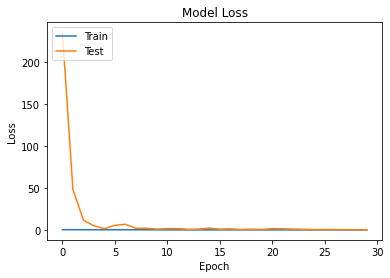

Plotting training accuracy



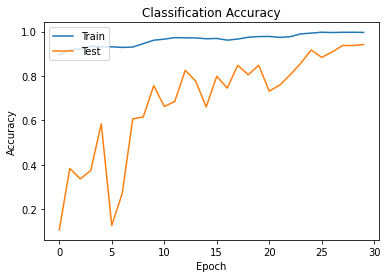

In [5]:
ResNet50_on_15_Classificaion(X_train, Y_train, X_test, Y_test, 30, 'Adam')